# CarND-Vehicle-Detection


## Histogram of Oriented Gradients (HOG)

### Explain how (and identify where in your code) you extracted HOG features from the training images. 

I have created a little framework to abstract feature detector, in file feature_detector.py:

#### Root abstract class
class FeatureExtractor:

Abstract class with abstract method extract(img)

#### Primitive extractors
class HOGFeatureExtractor(FeatureExtractor):

Extract HOG features

class ColorHistogramFeatureExtractor(FeatureExtractor):

Extract color histogram features

class ColorSpatialFeatureExtractor(FeatureExtractor):

Extract color spatial features

#### Composite extrator
class ConcatenateFeatureExtractor(FeatureExtractor):

You can add a number of extractor, and return concatenated features.


### Explain how you settled on your final choice of HOG parameters.

I mainly tryed HOG combination with color spaces and color histogram and spatial and I found that:
- I tryied RGB and HLS color space and this last one work better.
- color spatial doesn't give any improvement on detection.
- color histogram witn 16x16 give good results.
- HOG with L channel of HLS work fine.


### Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
	
I have created an abstraction of a binary classifier where can implement any classifier, althogh I have only implemented SVM classifier.

    def train(self,car_features, notcar_features):
    Receive two lists of features, train the model, after normalizing with a scaler, and output the validation accuracy value.
    
    def predict(self,features):
    Make a prediction.
    
    def save(self,fname), def load(self,fname):
    Save and load model and scaler in a pickle file.
    
I have tryied with LinearSVC and SVC and found better values with the later.

Below you can find a example code trainning a detector, using the classes commented above.

In [1]:
import glob
from feature_extractor import HOGFeatureExtractor,ConcatenateFeatureExtractor,ColorHistogramFeatureExtractor
from detector import Detector
d=Detector(colorSpace="HLS")
#Build a Feature Extractor concatenating a color histogram and a HOG
chfe=ColorHistogramFeatureExtractor(16)
hogfe=HOGFeatureExtractor()
hogfe.hog_channel=1 # L from HLS
cfe=ConcatenateFeatureExtractor()
cfe.add(chfe)
cfe.add(hogfe)
d.featureExtractor=cfe

/home/francisco/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def getData():
    cars = []
    notcars = []
    rootCar="vehicles/vehicles"
    images=glob.glob("vehicles/vehicles/GTI_Far/*.jpg")
    for image in images:
      cars.append(image)
    images=glob.glob(rootCar+"/GTI_Left/*.jpg")
    for image in images:
      cars.append(image)
    images=glob.glob(rootCar+"/GTI_MiddleClose/*.jpg")
    for image in images:
      cars.append(image)
    images=glob.glob(rootCar+"/GTI_Right/*.jpg")
    for image in images:
      cars.append(image)
    images=glob.glob(rootCar+"/KITTI_extracted/*.jpg")
    for image in images:
      cars.append(image)
    images=glob.glob("non-vehicles/non-vehicles/Extras/*.jpg")
    for image in images:
      notcars.append(image)
    images=glob.glob("non-vehicles/non-vehicles/GTI/*.jpg")
    for image in images:
      notcars.append(image)
    return cars,notcars
cars,notcars=getData()
print(len(cars),len(notcars))

8792 8968


In [3]:
#d.train(cars[:8700], notcars[:8700])
#d.clf.save("carDetectorAll.p")

In the code below it can be seen the detetor applied to images.

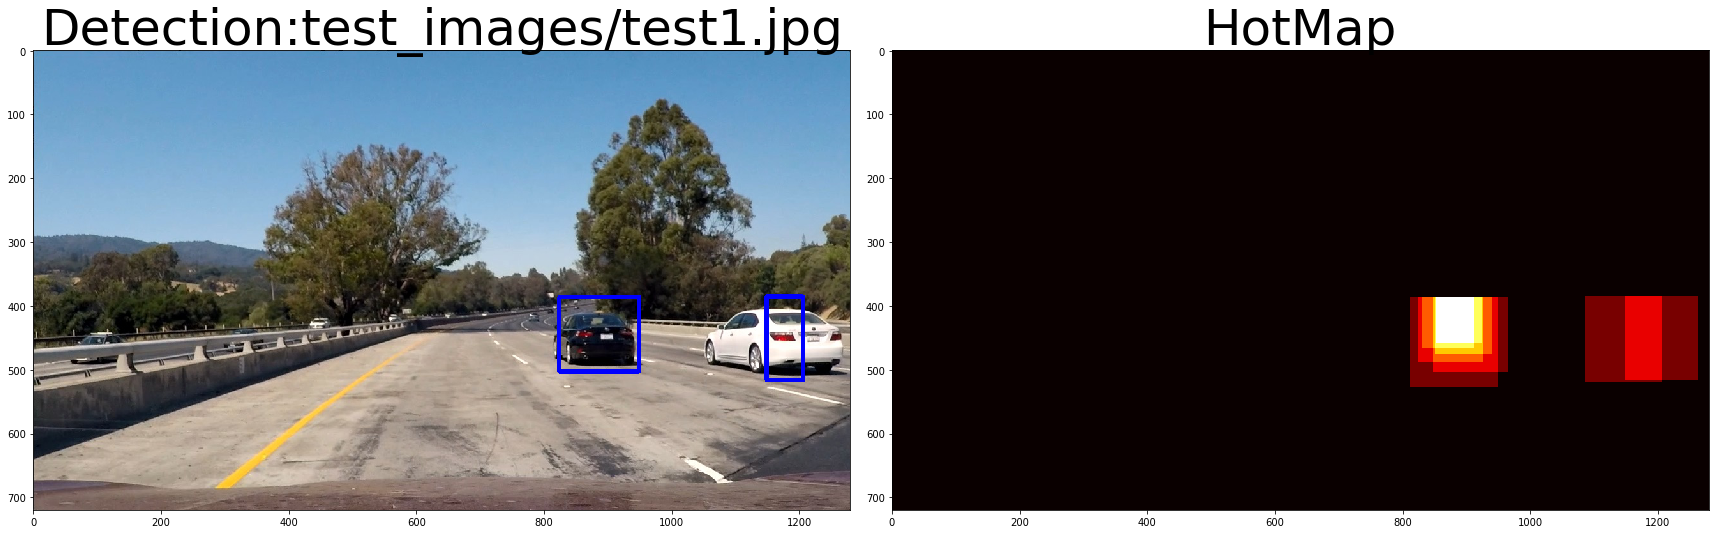

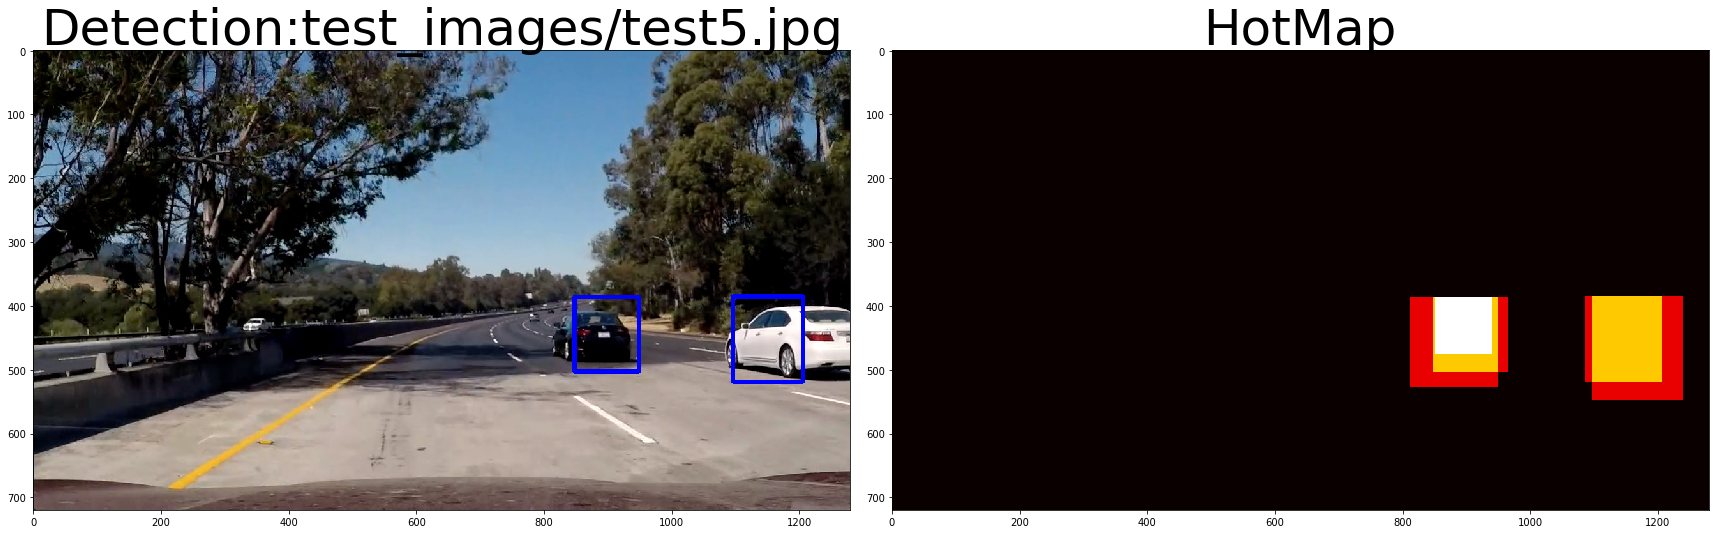

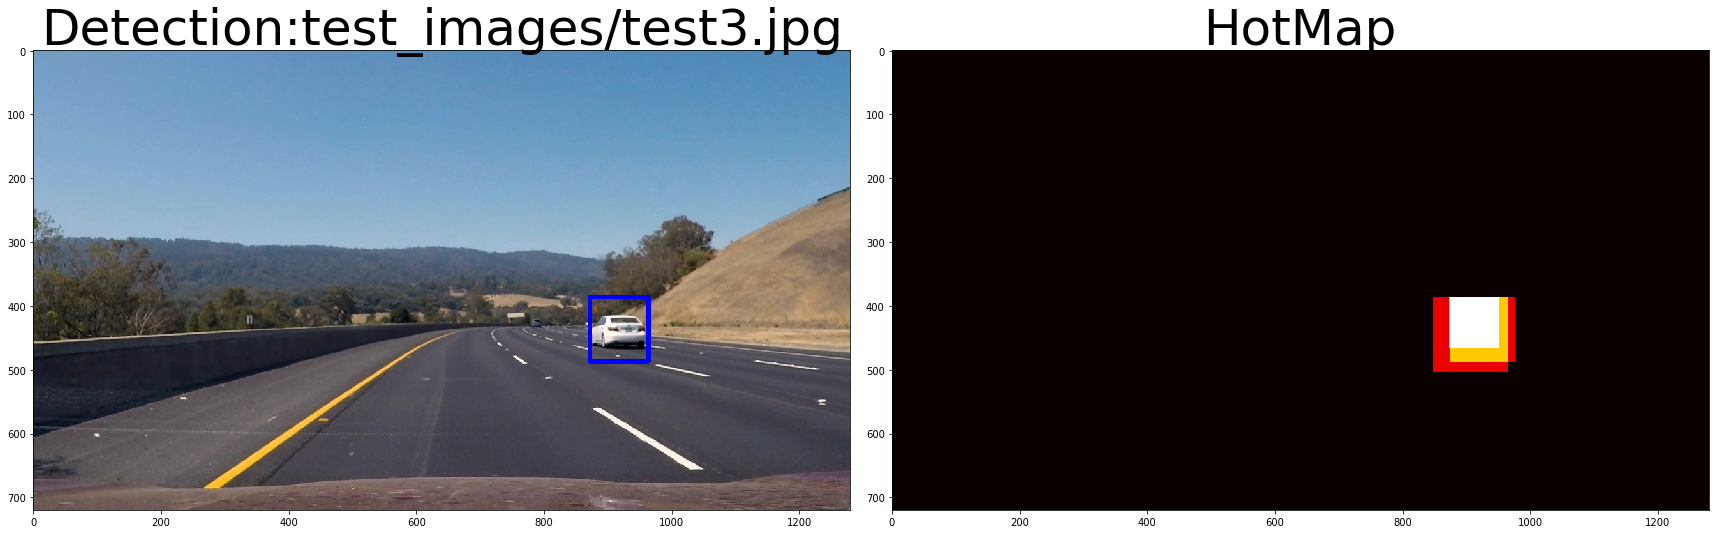

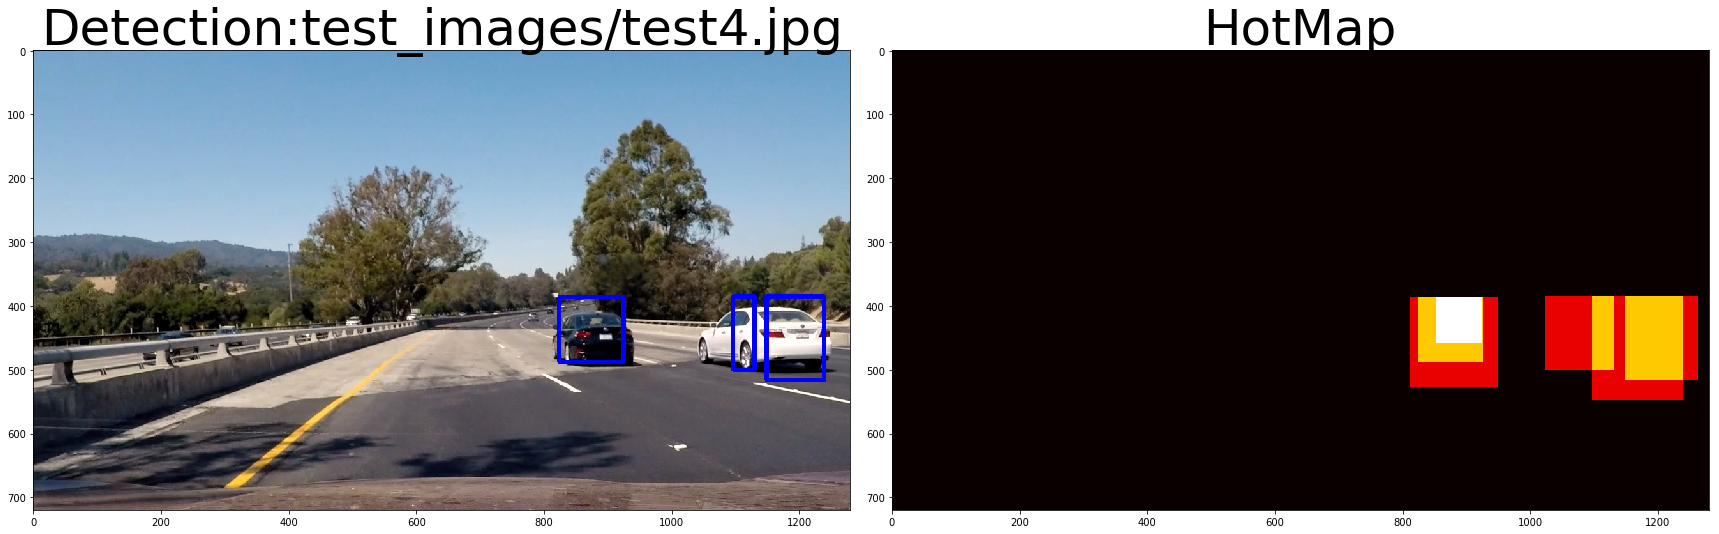

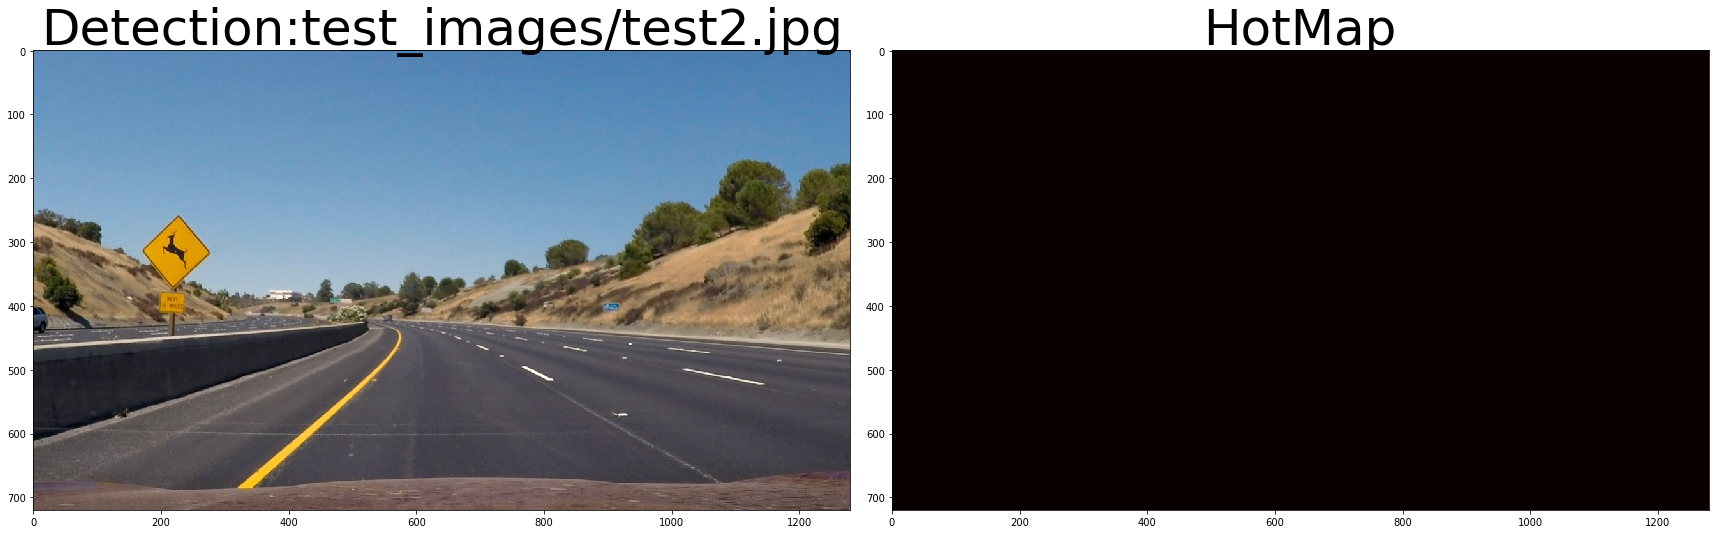

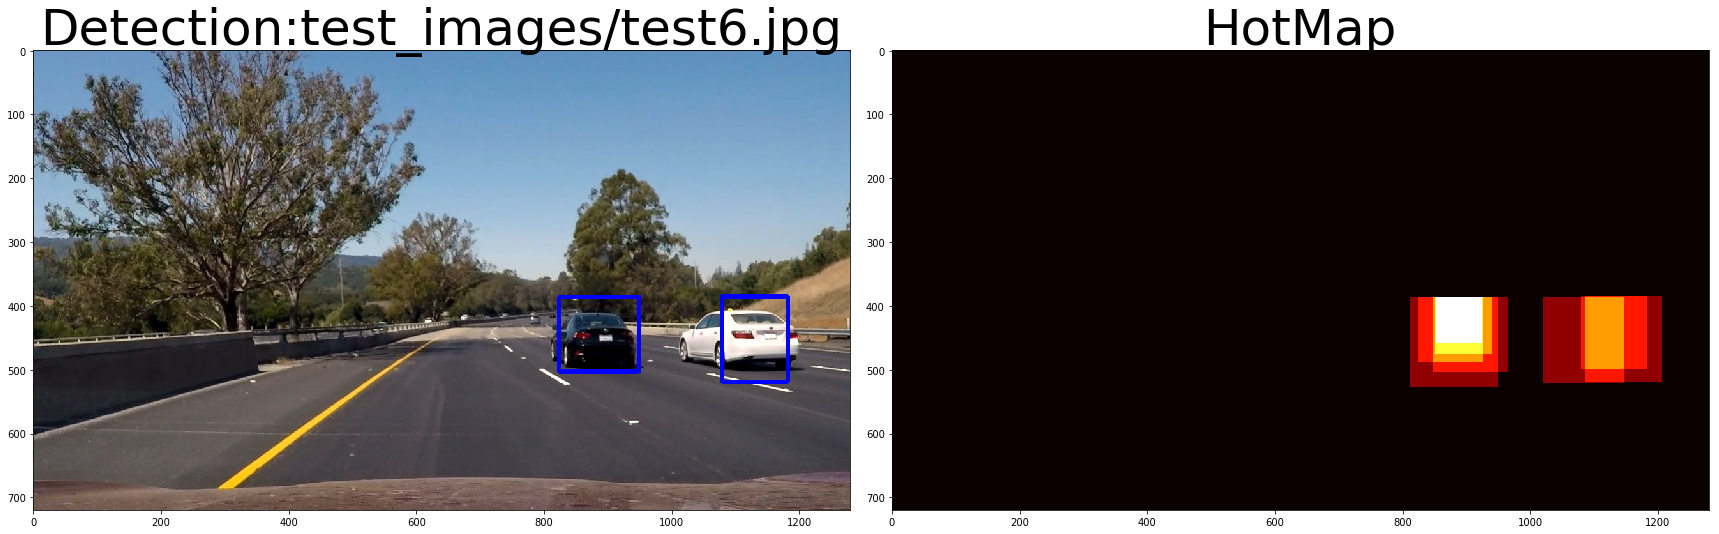

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from detector import Detector
%matplotlib inline
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
fimages = glob.glob('test_images/*.jpg')

d.clf.load("carDetectorAll.p")
d.featureExtractor=cfe
d.hitThreshold=1
for i,fName in enumerate(fimages):
    image = mpimg.imread(fName)
    draw_image = np.copy(image)
    hot_windows = d.detect(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(window_img)
    ax1.set_title('Detection:'+fName, fontsize=50)
    ax2.imshow(d.heatMap,cmap='hot')
    ax2.set_title('HotMap', fontsize=50)

## Sliding Window Search

I have defined a little framework abstracting the process of sliding window. Code is in windows.py.

#### Abstract class
- class WindowsFactory():
This class abstracts the building of windows. The method process return a list of windows to look for objects to be detected.

#### Primitive classes
- class WindowsSlider(WindowsFactory):

This class is not implemented but does the normal sliding window search. 

- class WindowsProject(WindowsFactory):

Set grid of 2D windows in the 3D road and then project to screen using calibration matrix. The search parameters are:
- self.window3D=((-1.0,0.0,0.0),(1.0,2.0,0.0)), windows to project is 2mx2m
- self.Xstart=-0.0, start search at left, we only look for car at right since car is in the left lane
- self.Xend  =9.0, finish search after 9m
- self.Xstep =1, overlap 1m each windows
- self.Zstart=10.0, start search 10m away fron the car
- self.Zend  =30.0, finish searching after 30m distance from the car
- self.Zstep =3, 3m step distance from the car



-Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
	
The class Detector uses the class WindowsProject to generate candidates to pass to the classifier. The size of the windows is given by the calibration matrix and the size of a normal car.

-Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?
	
In the images above can be seen how pipeline is working.

Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.)

In order to avoid false positives the class WindowsProject generate very good candidates.

## Video Implementation

-Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

The next two classes are the core of the tracking system. The class Car abstract a detected and tracked windows and uses a KalmanFilter from OpenCV to track the car. CarTracker is a collection of Car that are been tracked.
	

In [5]:
def windowCentroid(window):
    xc=(window[0][0]+window[1][0])/2.0
    yc=(window[0][1]+window[1][1])/2.0
    return np.array((xc,yc),np.float32)
class Car:
    def __init__(self,window):
        cWin=windowCentroid(window)
        #                         x        y  vx vy
        self.state=np.array([cWin[0], cWin[1], 0, 0]).T
        self.pVariance=10000 # process noise variance
        self.mVariance=10000 # measurement noise variance
        kalman = cv2.KalmanFilter(4,2)
        kalman.measurementMatrix = np.array([[1,0,0,0],
                                             [0,1,0,0]],np.float32)
        kalman.transitionMatrix = np.array([[1,0,1,0],
                                            [0,1,0,1],
                                            [0,0,1,0],
                                            [0,0,0,1]],np.float32)
        kalman.processNoiseCov = np.array([[1,0,0,0],
                                           [0,1,0,0],
                                           [0,0,1,0],
                                           [0,0,0,1]],np.float32) * self.pVariance
        kalman.measurementNoiseCov = np.array([[1,0],
                                               [0,1]],np.float32) * self.mVariance
        self.kalman=kalman
        self.distThresold=200
        self.confidence=1
        self.windows=[]
        self.windows.append(window)
        self.imgages=[]
    def getWindow(self):
        return self.windows[-1]
    def getPos(self):
        return self.state[0:2]
    def getVel(self):
        return self.state[2:4]
    def correct(self,window):
        self.windows.append(window)
        m=windowCentroid(window)
        self.kalman.correct(m)
    def predict(self):
        self.state=self.kalman.predict()
    def selectWindow(self,windows):
        minWin=None
        minDist=1e10
        for win in windows:
            cWin=windowCentroid(win)
            cCar=self.getPos()
            cDif=cWin-cCar
            dist=np.linalg.norm(cDif)
            if dist<minDist:
                minDist=dist
                minWin =win
        return minDist,minWin
    def incrementConfidence(self):
        if self.confidence<5:
            self.confidence+=1
    def decrementConfidence(self):
        if self.confidence>0:
            self.confidence-=1
    def step(self,windows):
        minDist,minWin=self.selectWindow(windows)
        if minDist<self.distThresold:
            windows.remove(minWin)
            self.correct(minWin)
            self.incrementConfidence()
        else:
            self.decrementConfidence()
        self.predict()
class CarTracker:
    def __init__(self,img,detector=Detector()):
        self.cars=[]
        self.detector=detector
        # create as many cars as windows are detected
        windows=self.detector.detect(img)
        for win in windows:
            c=Car(win)
            self.cars.append(c)
    def goodCars(self):
        return [c for c in self.cars if c.confidence>0]
    def process(self,img):
        windows=self.detector.detect(img)
        # update cars 
        for car in self.cars:
            car.step(windows)
        # select confident cars
        self.cars=self.goodCars()
        # add cars for windows not processed
        for win in windows:
            c=Car(win)
            self.cars.append(c)
    def goodWindows(self):
        return [c.getWindow() for c in self.cars if c.confidence>0]
        
 

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
imgCounter=0
cTracker=None
def process_image(image):
    global imgCounter,cTracker
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    if imgCounter==0:
        cTracker=CarTracker(image,d)
    else:
        cTracker.process(image)
    imgCounter+=1
    hot_windows = cTracker.goodWindows()
    #hot_windows = d.detect(image)
    nCars=len(cTracker.cars)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,"%d"%(nCars),(10,50), font, 1,(255,255,255),2)
    for i in range(nCars):
        y=100+i*50
        cv2.putText(image,"%d"%(cTracker.cars[i].confidence),(10,y), font, 1,(255,255,255),2) 
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    hm=np.zeros_like(window_img)
    #hm[:,:,0]=d.heatMap*40
    result=cv2.addWeighted(window_img, 0.5, hm, 0.5, 0)
    return result

In [11]:
white_output = 'project_video_output.mp4'

In [12]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [23:45<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 26min 42s, sys: 4.04 s, total: 26min 46s
Wall time: 23min 45s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video.

-Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.
	

A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur.

I use a kalmanfilter to track object and avoid false positives and cope with multiple overlapping.

## Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
	

Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.

When two cars are very near from each other it is dificult to keep track of both. In mi final result, in some fames only a windows wrap both cars. This could be improved with a better tracker and with a better detecto based on deep learning.
I would like to have had time to use this detector:
http://blog.dlib.net/2017/08/vehicle-detection-with-dlib-195_27.html